<h2><b>Importing libraries</b></h2>

In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import mplfinance as mpf
from pandas_datareader import data
import matplotlib.dates as mdates
import seaborn as sns
import yfinance as yf
import tensorflow as tf
from tensorflow import keras
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
import time
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Lasso

/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


<h2><b>Getting data</b></h2>

In [3]:
histVale = web.DataReader('VALE', data_source='yahoo', start="2018-01-01", end="2018-12-30")
histAzul = web.DataReader('AZUL4.SA', data_source='yahoo', start="2018-01-01", end="2018-12-30")
histBB = web.DataReader('BBAS3.SA', data_source='yahoo', start="2018-01-01", end="2018-12-30")
histPetro = web.DataReader('PBR', data_source='yahoo', start="2018-01-01", end="2018-12-30")
histItau = web.DataReader('ITUB', data_source='yahoo', start="2018-01-01", end="2018-12-30")
histTesla = web.DataReader('TSLA', data_source='yahoo', start="2018-01-01", end="2018-12-30")

In [4]:
historicStock = [histVale, histAzul, histBB, histPetro, histItau, histTesla]

In [5]:
monthlyInflation2018 = [0.0076, 0.0007, 0.0064, 0.0057, 0.0138, 0.0187, 0.0051, 0.0070, 0.0152, 0.0089, -0.0049, -0.0108]

<h2><b>Calculating daily inflation</b></h2>

In [6]:
dayMonth30 = [4,6,9,11]
dayMonth31 = [1,3,5,7,8,10,12]
        
def calculate_daily_inflation(monthlyInflation):
    dailyInflation = []
    inflationHigh = []
    inflationLow = []
    inflationOpen = []
    inflationClose = []
    
    for index, inf in enumerate(monthlyInflation):
        if np.isin(index, dayMonth30):
            dailyInflation.append((1 + inf) ** (1/float(30)))
        elif np.isin(index, dayMonth31):
            dailyInflation.append((1 + inf) ** (1/float(31)))
        else:
            dailyInflation.append((1 + inf) ** (1/float(28)))
    
    for stock in historicStock:
        stock["Month"] = stock.index.month
        total = 1
        inflation = []
        for index, row in stock.iterrows():
            month = int(row['Month'])
            if dailyInflation[month - 1] >= 1:
                total = total * dailyInflation[month - 1]
            else:
                total = total / dailyInflation[month - 1]
            inflation.append(total)
        stock["DailyInflation"] = inflation
        
    for stock in historicStock:
        for index, row in stock.iterrows():
            inflationHigh = round(stock["High"] / stock["DailyInflation"], 2)
            inflationLow = round(stock["Low"] / stock["DailyInflation"], 2)
            inflationOpen = round(stock["Open"] / stock["DailyInflation"], 2)
            inflationClose = round(stock["Close"] / stock["DailyInflation"], 2) 
        stock["InflationHigh"] = inflationHigh
        stock["InflationLow"] = inflationLow
        stock["InflationOpen"] = inflationOpen
        stock["InflationClose"] = inflationClose

In [7]:
calculate_daily_inflation(monthlyInflation2018)

In [8]:
historicStock[0]

,High,Low,Open,Close,Volume,Adj Close,Month,DailyInflation,InflationHigh,InflationLow,InflationOpen,InflationClose
Date,,,,,,,,,,,,
2018-01-02,12.80,12.51,12.55,12.77,19189400.0,11.463087,1,1.000270,12.80,12.51,12.55,12.77
2018-01-03,12.87,12.68,12.80,12.85,20449600.0,11.534901,1,1.000541,12.86,12.67,12.79,12.84
2018-01-04,13.09,12.82,13.03,12.83,22033100.0,11.516948,1,1.000812,13.08,12.81,13.02,12.82
2018-01-05,13.09,12.73,12.80,13.09,20042800.0,11.750339,1,1.001082,13.08,12.72,12.79,13.08
2018-01-08,13.32,13.18,13.26,13.32,17507000.0,11.956799,1,1.001353,13.30,13.16,13.24,13.30
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-21,13.23,12.83,13.09,12.90,21755100.0,12.052124,12,1.073060,12.33,11.96,12.20,12.02
2018-12-24,13.03,12.59,12.82,12.60,11224100.0,11.771843,12,1.073449,12.14,11.73,11.94,11.74
2018-12-26,13.07,12.55,12.68,13.07,16587500.0,12.210951,12,1.073837,12.17,11.69,11.81,12.17


<h2><b>Calculating short and long EMAs, MACD and Signal lines</b></h2>

In [9]:
def calculate_lines():
    for stock in historicStock:
        stock["ShortEMA"] = stock["Close"].ewm(span = 12, adjust = False).mean()
        stock["LongEMA"] = stock["Close"].ewm(span = 26, adjust = False).mean()
        stock["MACD"] = stock["ShortEMA"] - stock["LongEMA"]
        stock["Signal"] = stock["MACD"].ewm(span = 9, adjust = False).mean()
        stock["InflationShortEMA"] = stock["InflationClose"].ewm(span = 12, adjust = False).mean()
        stock["InflationLongEMA"] = stock["InflationClose"].ewm(span = 26, adjust = False).mean()
        stock["InflationMACD"] = stock["InflationShortEMA"] - stock["InflationLongEMA"]
        stock["InflationSignal"] = stock["InflationMACD"].ewm(span = 9, adjust = False).mean()

In [10]:
calculate_lines()

In [11]:
def calculate_bollinger_bands():
    for stock in historicStock:
        stock["30_MA"] = stock["Close"].rolling(window=30).mean()
        stock["30_STD"] = stock["Close"].rolling(window=30).std()
        stock["UpperBollinger"] = stock["30_MA"] + 2 * stock["30_STD"]
        stock["LowerBollinger"] = stock["30_MA"] - 2 * stock["30_STD"]
        stock["DifferenceUpper"] = stock["UpperBollinger"] - stock["Close"]
        stock["DifferenceLower"] = stock["LowerBollinger"] - stock["Close"]
        
        plt.plot(stock["LowerBollinger"], label="Lower")
        plt.plot(stock["UpperBollinger"], label="Upper")
        plt.plot(stock["Close"], label="Close")
        plt.legend()
        plt.show()

In [12]:
def calculate_bollinger_bands_stock(stock):
    stock["30_MA"] = stock["Close"].rolling(window=30).mean()
    stock["30_STD"] = stock["Close"].rolling(window=30).std()
    stock["UpperBollinger"] = stock["30_MA"] + 2 * stock["30_STD"]
    stock["LowerBollinger"] = stock["30_MA"] - 2 * stock["30_STD"]
    stock["DifferenceUpper"] = stock["UpperBollinger"] - stock["Close"]
    stock["DifferenceLower"] = stock["LowerBollinger"] - stock["Close"]

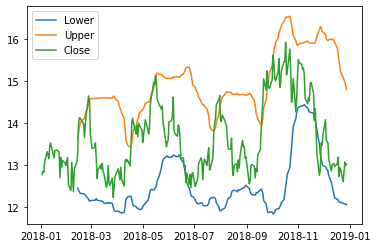

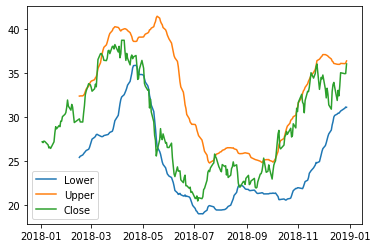

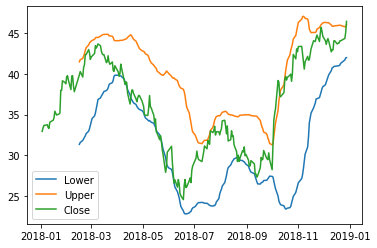

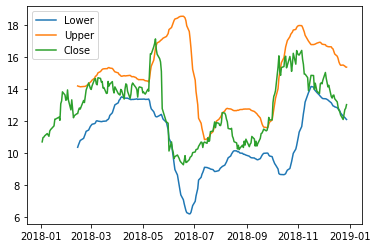

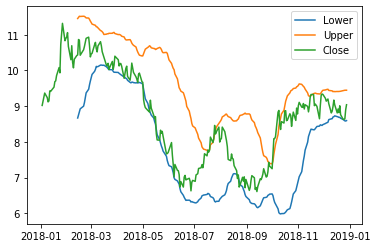

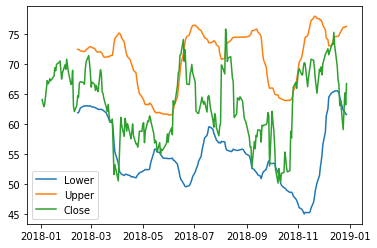

In [13]:
calculate_bollinger_bands()

<h2><b>Calculating Relative Strength Index (RSI)</b></h2>

In [14]:
def calculate_RSI(window):
    for stock in historicStock:
        delta = stock["Close"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        RS_up = up_days.rolling(window).mean()
        RS_down = down_days.rolling(window).mean()
        rsi= 100-100/(1+RS_up/RS_down)
        stock["RSI"] = rsi
        
        delta = stock["InflationClose"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        RS_up = up_days.rolling(window).mean()
        RS_down = down_days.rolling(window).mean()
        rsi= 100-100/(1+RS_up/RS_down)
        stock["InflationRSI"] = rsi

In [15]:
def calculate_RSI_stock(window, stock, inflation=False):
    if inflation == False:
        delta = stock["Close"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        RS_up = up_days.rolling(window).mean()
        RS_down = down_days.rolling(window).mean()
        rsi= 100-100/(1+RS_up/RS_down)
        stock["RSI"] = rsi
    else:
        delta = stock["InflationClose"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        RS_up = up_days.rolling(window).mean()
        RS_down = down_days.rolling(window).mean()
        rsi= 100-100/(1+RS_up/RS_down)
        stock["InflationRSI"] = rsi

In [16]:
calculate_RSI(14)

<h2><b>Function to plot RSI</b></h2>

In [17]:
def plot_rsi_close(stock, stockName, inflation=False):
    scaler = MinMaxScaler()
    stockScaled = pd.DataFrame(scaler.fit_transform(stock), columns=stock.columns)

    plt.figure(figsize = (20, 10))
    if inflation == False:
        ax = stockScaled["RSI"].plot()
        stockScaled["Close"].plot()
    else:
        ax = stockScaled["InflationRSI"].plot()
        stockScaled["InflationClose"].plot()
    ax.axhline(y = 0.7, color = 'red')
    ax.axhline(y = 0.3, color = 'lime')
    plt.title(f'Relação RSI e Close da {stockName}')
    plt.legend()
    plt.show()

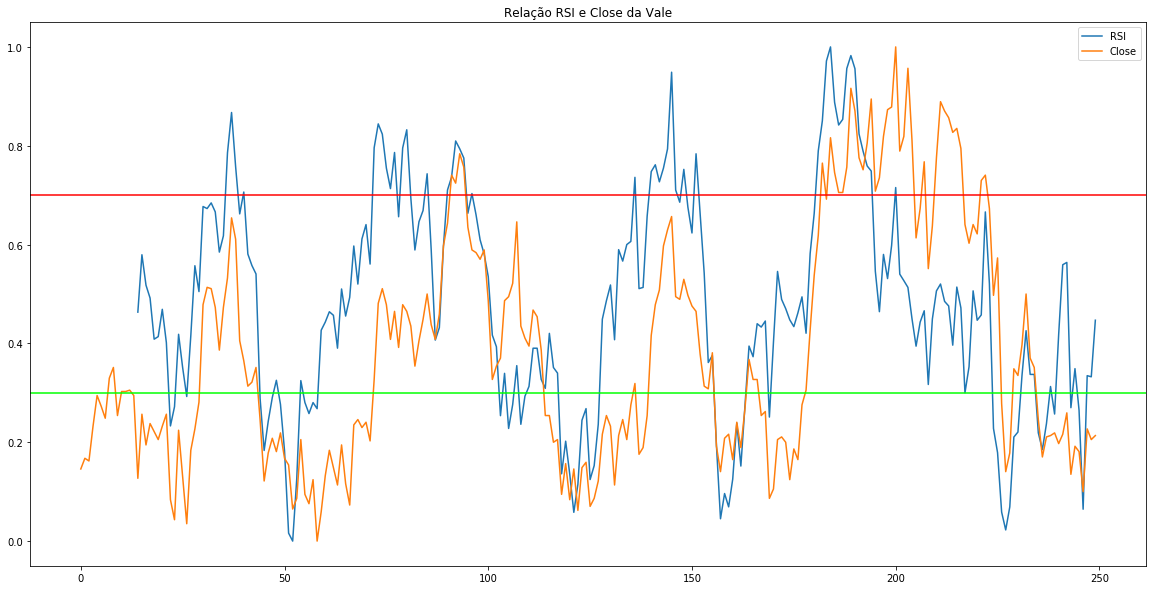

In [18]:
plot_rsi_close(historicStock[0], 'Vale')

<h2><b>Calculating Money Flow Index (MFI)</b></h2>

In [19]:
def calculate_MFI(window):
    for stock in historicStock:
        stock["TypicalPrice"] = (stock["High"] + stock["Low"] + stock["Close"]) / 3
        delta = stock["TypicalPrice"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        up_days[delta>0]=stock["TypicalPrice"]
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        down_days[delta<=0]=stock["TypicalPrice"]
        stock["1DayPositiveMoneyFlow"] = up_days * stock["Volume"]
        stock["1DayNegativeMoneyFlow"] = down_days * stock["Volume"]
        stock["nDayPositiveMoneyFlow"] = stock["1DayPositiveMoneyFlow"].rolling(window).sum()
        stock["nDayNegativeMoneyFlow"] = stock["1DayNegativeMoneyFlow"].rolling(window).sum()
        stock["MoneyFlowRatio"] = stock["nDayPositiveMoneyFlow"] / stock["nDayNegativeMoneyFlow"]
        stock["MoneyFlowIndex"] = 100 - (100 / (1 + stock["MoneyFlowRatio"]))

        stock["InflationTypicalPrice"] = (stock["InflationHigh"] + stock["InflationLow"] + stock["InflationClose"]) / 3
        delta = stock["InflationTypicalPrice"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        up_days[delta>0]=stock["InflationTypicalPrice"]
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        down_days[delta<=0]=stock["InflationTypicalPrice"]
        stock["Inflation1DayPositiveMoneyFlow"] = up_days * stock["Volume"]
        stock["Inflation1DayNegativeMoneyFlow"] = down_days * stock["Volume"]
        stock["InflationnDayPositiveMoneyFlow"] = stock["Inflation1DayPositiveMoneyFlow"].rolling(window).sum()
        stock["InflationnDayNegativeMoneyFlow"] = stock["Inflation1DayNegativeMoneyFlow"].rolling(window).sum()
        stock["InflationMoneyFlowRatio"] = stock["InflationnDayPositiveMoneyFlow"] / stock["InflationnDayNegativeMoneyFlow"]
        stock["InflationMoneyFlowIndex"] = 100 - (100 / (1 + stock["InflationMoneyFlowRatio"]))

In [20]:
def calculate_MFI_stock(window, stock, inflation=False):
    if inflation == False:
        stock["TypicalPrice"] = (stock["High"] + stock["Low"] + stock["Close"]) / 3
        delta = stock["TypicalPrice"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        up_days[delta>0]=stock["TypicalPrice"]
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        down_days[delta<=0]=stock["TypicalPrice"]
        stock["1DayPositiveMoneyFlow"] = up_days * stock["Volume"]
        stock["1DayNegativeMoneyFlow"] = down_days * stock["Volume"]
        stock["nDayPositiveMoneyFlow"] = stock["1DayPositiveMoneyFlow"].rolling(window).sum()
        stock["nDayNegativeMoneyFlow"] = stock["1DayNegativeMoneyFlow"].rolling(window).sum()
        stock["MoneyFlowRatio"] = stock["nDayPositiveMoneyFlow"] / stock["nDayNegativeMoneyFlow"]
        stock["MoneyFlowIndex"] = 100 - (100 / (1 + stock["MoneyFlowRatio"]))
    else:
        stock["InflationTypicalPrice"] = (stock["InflationHigh"] + stock["InflationLow"] + stock["InflationClose"]) / 3
        delta = stock["InflationTypicalPrice"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        up_days[delta>0]=stock["InflationTypicalPrice"]
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        down_days[delta<=0]=stock["InflationTypicalPrice"]
        stock["Inflation1DayPositiveMoneyFlow"] = up_days * stock["Volume"]
        stock["Inflation1DayNegativeMoneyFlow"] = down_days * stock["Volume"]
        stock["InflationnDayPositiveMoneyFlow"] = stock["Inflation1DayPositiveMoneyFlow"].rolling(window).sum()
        stock["InflationnDayNegativeMoneyFlow"] = stock["Inflation1DayNegativeMoneyFlow"].rolling(window).sum()
        stock["InflationMoneyFlowRatio"] = stock["InflationnDayPositiveMoneyFlow"] / stock["InflationnDayNegativeMoneyFlow"]
        stock["InflationMoneyFlowIndex"] = 100 - (100 / (1 + stock["InflationMoneyFlowRatio"]))

In [21]:
calculate_MFI(14)

<h2><b>Function to plot MFI</b></h2>

In [22]:
def plot_mfi(stock, stockName, inflation=False):

    plt.figure(figsize = (20, 10))
    if inflation == False:
        ax = stock["MoneyFlowIndex"].plot()
    else:
        ax = stock["InflationMoneyFlowIndex"].plot()
    ax.axhline(y = 20, color = 'red')
    ax.axhline(y = 80, color = 'lime')
    plt.title(f'MFI da {stockName}')
    plt.legend()
    plt.show()

<h2><b>Calculating Stochastic Oscillator</b></h2>

In [23]:
def calculate_stochastic_oscillator(window):
    for stock in historicStock:
        nHigh = stock["High"].rolling(window).max()
        nLow = stock["Low"].rolling(window).min()
        stock["StochasticOscillator"] = ((stock["Close"] - nLow) / (nHigh - nLow)) * 100
        
        nHigh = stock["InflationHigh"].rolling(window).max()
        nLow = stock["InflationLow"].rolling(window).min()
        stock["InflationStochasticOscillator"] = ((stock["InflationClose"] - nLow) / (nHigh - nLow)) * 100

In [24]:
def calculate_stochastic_oscillator_stock(window, stock, inflation=False):
    if inflation == False:
        nHigh = stock["High"].rolling(window).max()
        nLow = stock["Low"].rolling(window).min()
        stock["StochasticOscillator"] = ((stock["Close"] - nLow) / (nHigh - nLow)) * 100
    else:  
        nHigh = stock["InflationHigh"].rolling(window).max()
        nLow = stock["InflationLow"].rolling(window).min()
        stock["InflationStochasticOscillator"] = ((stock["InflationClose"] - nLow) / (nHigh - nLow)) * 100

In [25]:
calculate_stochastic_oscillator(14)

<h2><b>Function to plot Stochastic Oscillator</b></h2>

In [26]:
def plot_stochastic_oscillator(stock, stockName, inflation=False):

    plt.figure(figsize = (20, 10))
    if inflation == False:
        ax = stock["StochasticOscillator"].plot()
    else:
        ax = stock["InflationStochasticOscillator"].plot()
    ax.axhline(y = 20, color = 'red')
    ax.axhline(y = 80, color = 'lime')
    plt.title(f'Oscilador estocástico da {stockName}')
    plt.legend()
    plt.show()

<h2><b>Function to plot correlation matrix</b></h2>

In [27]:
def show_corr_matrix(stock, inflation=False):

    if inflation == False:
        corrMatrix = stock[["Close", "RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "LongEMA", "MACD"]].corr()
    else:
        corrMatrix = stock[["InflationClose", "InflationRSI", "InflationMoneyFlowIndex", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD"]].corr()

    sns.heatmap(corrMatrix, annot=True)
    plt.figure(figsize = (100,100))
    plt.show()

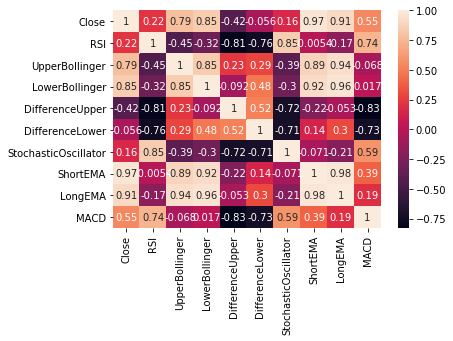

<Figure size 7200x7200 with 0 Axes>

In [28]:
show_corr_matrix(historicStock[4])

<h2><b>Function to predict traditional SVM</b></h2>

In [29]:
svmRegressorClose = svm.SVR(kernel="linear")
svmRegressorHigh = svm.SVR(kernel="linear")
svmRegressorLow = svm.SVR(kernel="linear")
svmRegressorNu = svm.NuSVR(kernel="linear")

In [30]:
def predict_svm_traditional(stock, inflation=False, feature='close'):
    if feature == 'close':
        if inflation == False:
            stockX = stock[["RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
            stockY = stock["Close"][30:]
        else:
            stockX = stock[["InflationRSI", "InflationStochasticOscillator", "InflationShortEMA", "InflationMACD"]][15:]
            stockY = stock["InflationClose"][15:]
        X = np.array(stockX)
        y = np.array(stockY)
        X = X[:-2]
        y = y[2:]
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.6, shuffle=False)

        svmRegressorClose.fit(X_train, y_train)
        print(svmRegressorClose)

        print(X_test)

        y_pred = svmRegressorClose.predict(X_test)
        print('Predicted values: ', y_pred)
        print('Testing values: ', y_test)
#         print('Coefficients: \n', svmRegressorClose.coef_)

        return y_pred, y_test, y_train
    elif feature == 'high':
        if inflation == False:
            stockX = stock[["RSI", "ShortEMA", "MACD"]][15:]
            stockY = stock["High"][15:]
        else:
            stockX = stock[["InflationRSI", "InflationShortEMA", "InflationMACD"]][15:]
            stockY = stock["InflationHigh"][15:]
        X = np.array(stockX)
        y = np.array(stockY)
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

        svmRegressorHigh.fit(X_train, y_train)

        print(X_test)

        y_pred = svmRegressorHigh.predict(X_test)
        print('Predicted values: ', y_pred)
        print('Testing values: ', y_test)
        print('Coefficients: \n', svmRegressorHigh.coef_)

        return y_pred, y_test, y_train
    elif feature == 'low':
        if inflation == False:
            stockX = stock[["RSI","ShortEMA", "MACD"]][15:]
            stockY = stock["Low"][15:]
        else:
            stockX = stock[["InflationRSI", "InflationShortEMA", "InflationMACD"]][15:]
            stockY = stock["InflationLow"][15:]
        X = np.array(stockX)
        y = np.array(stockY)
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

        svmRegressorLow.fit(X_train, y_train)

        print(X_test)

        y_pred = svmRegressorLow.predict(X_test)
        print('Predicted values: ', y_pred)
        print('Testing values: ', y_test[1:])
        print('Coefficients: \n', svmRegressorLow.coef_)

        return y_pred, y_test[1:], y_train
        

In [31]:
def predict_plot_svm(stock, inflation=False, feature='close'):
    y_pred, y_test, y_train = predict_svm_traditional(stock, inflation, feature)
    
    print('R^2 value: ', r2_score(y_test, y_pred))
    print('MAE score: ', mean_absolute_error(y_test, y_pred))
    print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
    
    plt.plot(y_test, label="Real value")
    plt.plot(range(len(y_pred)), y_pred, marker="x", label="Prediction")
    plt.legend()
    plt.show()

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
[[ 2.67175511e+01  1.47005518e+01  1.23574482e+01  1.86055166e+00
  -4.82551970e-01  1.44385280e+01  1.32755220e+01 -1.53029446e-01]
 [ 3.40277718e+01  1.46795764e+01  1.24097570e+01  1.55957648e+00
  -7.10242905e-01  2.94117767e+01  1.32515955e+01 -1.54100256e-01]
 [ 2.84246635e+01  1.46827741e+01  1.24005592e+01  1.75277382e+00
  -5.29441096e-01  1.92513707e+01  1.32021194e+01 -1.68339743e-01]
 [ 3.62459604e+01  1.46819252e+01  1.24067415e+01  1.46192491e+00
  -8.13258783e-01  3.47593910e+01  1.32048703e+01 -1.54443735e-01]
 [ 4.40828444e+01  1.46825299e+01  1.24461368e+01  1.09252971e+00
  -1.14386333e+00  6.21951368e+01  1.32641210e+01 -1.12280846e-01]
 [ 4.26934060e+01  1.46836363e+01  1.24576970e+01  1.24363671e+00
  -9.82302547e-01  6.17021262e+01  1.32911793e+01 -8.99335469e-02]
 [ 4.70031462e+01  1.46840927e+01  1.24592406e+01 

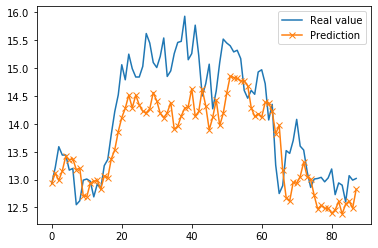

In [32]:
predict_plot_svm(historicStock[0])

In [33]:
# def predict_svm_traditional_forward_correct(stock, n, inflation=False):
#     y_pred = []
#     stock = stock[["Close", "High", "Low", "RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "LongEMA", "MACD"]][30:]
    
#     if inflation == False:
#         stockX = stock[["RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]]
#         stockXHiLo = stock[["RSI", "ShortEMA", "MACD"]]
#         stockY = stock["Close"]
#         stockYHi = stock["High"]
#         stockYLo = stock["Low"]
#     else:
#         stockX = stock[["InflationRSI", "InflationStochasticOscillator", "InflationShortEMA", "InflationMACD", "InflationHigh", "InflationLow"]]
#         stockY = stock["InflationClose"]
#     X = np.array(stockX)
#     y = np.array(stockY)
    
#     df_train, df_test = train_test_split(stock, random_state=42, shuffle=False)
#     print(len(df_train.index))
#     print(len(df_test.index))
#     X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)
#     print(len(X_train))
#     print(len(X_test))
#     X_test = np.append(X_train[-30:], [X_test[0]], axis=0)
#     y_pred = [y_train[-1]]
    
    
#     df_final = df_train[-30:]
    

#     svmRegressorClose.fit(X_train, y_train)
    
    
#     X = np.array(stockXHiLo)
#     y = np.array(stockYHi)
#     X_train_high, X_test_high, y_train_high, y_test_high = train_test_split(X, y, random_state=42, shuffle=False)
#     svmRegressorHigh.fit(X_train_high, y_train_high)
    
    
#     X = np.array(stockXHiLo)
#     y = np.array(stockYLo)
#     X_train_low, X_test_low, y_train_low, y_test_low = train_test_split(X, y, random_state=42, shuffle=False)
#     svmRegressorLow.fit(X_train_low, y_train_low)
    
    
    
#     i = 0
    
#     while i < n:
        
#                                                             ##RSI ESTA DANDO MUITO ALTO
#         shortEma = df_final["Close"][-12:].mean()
#         longEma = df_final["Close"][-26:].mean()
#         macd = shortEma - longEma
                 
        
#         df_final = df_final.append({"Close": y_pred[-1], "High": 0, "Low": 0,"RSI": 0, "UpperBollinger": 0, "LowerBollinger": 0, "DifferenceUpper": 0, "DifferenceLower": 0, "StochasticOscillator": 0, "ShortEMA": shortEma, "LongEMA": longEma, "MACD": macd}, ignore_index=True)
#         calculate_RSI_stock(14, df_final)
#         high_pred = svmRegressorHigh.predict(np.array(df_final[["RSI", "ShortEMA", "MACD"]])[-1].reshape(1, -1))
#         low_pred = svmRegressorLow.predict(np.array(df_final[["RSI", "ShortEMA", "MACD"]])[-1].reshape(1, -1))
#         df_final["High"].iloc[-1] = high_pred if y_pred[-1] < high_pred else y_pred[-1]
#         df_final["Low"].iloc[-1] = low_pred if y_pred[-1] > low_pred else y_pred[-1]
        
#         pred = svmRegressorClose.predict((X_test[-1]).reshape(1, -1))
#         df_final["Close"].iloc[-1] = pred[0]
#         y_pred = np.append(y_pred, pred[0])
        
#         calculate_bollinger_bands_stock(df_final)
#         calculate_stochastic_oscillator_stock(14, df_final)
        
        
#         X_test = np.append(X_test, [(df_final[["RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]].iloc[-1]).to_numpy()], axis=0)
        
#         i += 1
        
# #     print('R^2 value: ', r2_score(y_test, y_pred))
# #     print('MAE score: ', mean_absolute_error(y_test, y_pred))
# #     print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
        
#     plt.plot(y_test[:n], label="Real value")
#     plt.plot(y_pred, label="Prediction")
#     plt.legend()
#     plt.show()

In [34]:
# predict_svm_traditional_forward_correct(historicStock[3], 14)

In [35]:
# def predict_svm_traditional_forward(stock, n, inflation=False):
#     y_test = []
#     y_pred = []
#     provStock = stock[["RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "LongEMA", "MACD", "High", "Low", "Close"]][:30]
#     y_test = np.array(stock["Close"][30:(30+n)])
#     if inflation == False:
#         stockX = provStock[["RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]]
#         stockY = provStock["Close"]
#     else:
#         stockX = provStock[["InflationRSI", "InflationStochasticOscillator", "InflationShortEMA", "InflationMACD", "InflationHigh", "InflationLow"]]
#         stockY = provStock["InflationClose"]
#     X = np.array(stockX)
#     y = np.array(stockY)
    
#     i = 0
#     while i < n:
#         y[-1] = svmRegressorClose.predict((X[-1]).reshape(1, -1))
#         provStock["Close"].iloc[-1] = y[-1]
#         y_pred.append(y[-1])

#         shortEma = y[-12:].mean()
#         longEma = y[-26:].mean()
#         macd = shortEma - longEma
        
#         provStock = provStock.append({"RSI": 0, "UpperBollinger": 0, "LowerBollinger": 0, "DifferenceUpper": 0, "DifferenceLower": 0, "StochasticOscillator": 0, "ShortEMA": shortEma, "LongEMA": longEma, "MACD": macd, "High": 0, "Low": 0, "Close": y[-1]}, ignore_index=True)
#         calculate_RSI_stock(14, provStock)
#         high_pred = svmRegressorHigh.predict(np.array(provStock[["RSI", "ShortEMA", "MACD"]])[-1].reshape(1, -1))
#         low_pred = svmRegressorLow.predict(np.array(provStock[["RSI", "ShortEMA", "MACD"]])[-1].reshape(1, -1))
#         provStock["High"].iloc[-1] = high_pred
#         provStock["Low"].iloc[-1] = low_pred
        
#         calculate_bollinger_bands_stock(provStock)
#         calculate_stochastic_oscillator_stock(14, provStock)
#         X = np.array(provStock[["RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]])
#         print(X)
#         y = np.append(y, [0])
#         i += 1
        
# #     print('R^2 value: ', r2_score(y_test, y_pred))
# #     print('MAE score: ', mean_absolute_error(y_test, y_pred))
# #     print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))

#     plt.plot(y_test, label="Real value")
#     plt.plot(y_pred, label="Prediction")
#     plt.legend()
#     plt.show()

# #     svmRegressor.fit(X_train, y_train)
    
# #     print(X_test)
    
# #     y_pred = svmRegressor.predict(X_test)
# #     print('Predicted values: ', y_pred)
# #     print('Testing values: ', y_test)
# #     print('Coefficients: \n', svmRegressor.coef_)
    
# #     return y_pred, y_test, y_train

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
[[ 2.46913528e+01  8.62217431e+00  7.03782553e+00  1.64884143e+00
   6.44926521e-02  3.91303861e+00  7.52615836e+00 -1.40622328e-01]
 [ 2.71641715e+01  8.63794132e+00  7.00872518e+00  1.56460853e+00
  -6.46076105e-02  1.59183488e+01  7.45649289e+00 -1.66328697e-01]
 [ 1.27219012e+01  8.69611580e+00  6.90566175e+00  1.96278269e+00
   1.72328640e-01  1.96078266e+00  7.34523754e+00 -2.11696012e-01]
 [ 1.55963501e+01  8.73968161e+00  6.80342927e+00  1.95301474e+00
   1.67623953e-02  6.56372874e+00  7.25930359e+00 -2.40573169e-01]
 [ 2.45614252e+01  8.75781592e+00  6.74529497e+00  1.75114878e+00
  -2.61372169e-01  2.04918379e+01  7.22043644e+00 -2.42906269e-01]
 [ 2.48520977e+01  8.77553894e+00  6.66934975e+00  1.87553884e+00
  -2.30650344e-01  1.72588945e+01  7.17113854e+00 -2.50475086e-01]
 [ 3.08157215e+01  8.78323621e+00  6.61543027e+00 

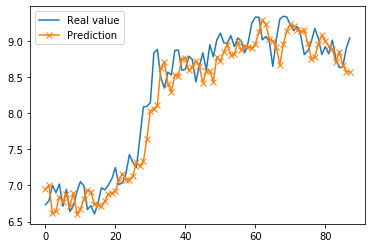

In [36]:
predict_plot_svm(historicStock[4])

In [37]:
# predict_svm_traditional_forward(historicStock[4], 14) 

<h2><b>Function to predict Nu SVM</b></h2>

In [38]:
def predict_svm_nu(stock, inflation=False):
    if inflation == False:
        stockX = stock[["RSI", "MoneyFlowIndex", "StochasticOscillator", "ShortEMA", "MACD"]][15:]
        stockY = stock["Close"][15:]
    else:
        stockX = stock[["InflationRSI", "InflationMoneyFlowIndex", "InflationStochasticOscillator", "InflationShortEMA", "InflationMACD"]][15:]
        stockY = stock["InflationClose"][15:]
    X = np.array(stockX)
    y = np.array(stockY)
    X = X[:-1]
    y = y[1:]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

    svmRegressorNu.fit(X_train, y_train)
    
    y_pred = svmRegressorNu.predict(X_test)
    print('Predicted values: ', y_pred)
    print('Testing values: ', y_test)
    print('Coefficients: \n', svmRegressorNu.coef_)
    
    return y_pred, y_test, y_train

In [39]:
def predict_plot_svm_nu(stock, inflation=False):
    y_pred, y_test, y_train = predict_svm_nu(stock, inflation)
    
    print('R^2 value: ', r2_score(y_test, y_pred))
    print('MAE score: ', mean_absolute_error(y_test, y_pred))
    print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
    
    plt.plot(y_test, label="Real value")
    plt.plot(y_pred, label="Prediction")
    plt.legend()
    plt.show()

Predicted values:  [29.03834056 31.22140619 31.9332963  32.87300074 33.68757582 34.84583402
 35.79254349 35.853875   36.2000604  36.85736754 37.91479929 38.60353992
 38.87397358 39.43894499 39.99086173 40.19781417 39.77595701 40.36930395
 41.26435854 40.91223329 42.06402346 42.45217985 43.18477448 43.5366323
 42.95262265 42.10741788 41.38961115 41.92050068 42.43473339 42.11204691
 42.17911867 43.21204039 43.68370957 43.95869073 44.15126508 44.35693818
 43.97569412 44.79083592 45.62809926 45.66250334 45.52343874 44.94158039
 44.47326911 44.8049198  44.83035087 44.0135664  42.57221001 42.71188137
 42.49249366 43.47589204 43.66126467 43.11746481 43.06588143 43.22324382
 43.66289663 44.18824915 44.72990173 45.54115831]
Testing values:  [31.43000031 34.27999878 35.11999893 35.74000168 39.20000076 39.
 37.34999847 37.20000076 37.72000122 39.36999893 39.70999908 39.25
 39.58000183 39.84999847 39.99000168 39.09999847 40.09999847 42.41999817
 41.86999893 43.09999847 42.75       43.38000107 43.4

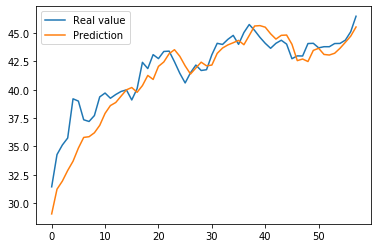

In [48]:
predict_plot_svm_nu(historicStock[2])

<h2><b>Scaling data for LSTM</b></h2>

In [41]:
# scaler = MinMaxScaler()
# stockScaled = []
# stocksScaled = []

# for stock in historicStock:
#     stocksScaled.append(stock)
    
# for stock in stocksScaled:
#     stockScaled.append(pd.DataFrame(scaler.fit_transform(stock), columns=historicStock[0].columns))

In [42]:
# def predict_LSTM(stock, inflation=False):
#     if inflation == False:
#         stockX = stock[["RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
#         stockY = stock["Close"][30:]
#     else:
#         stockX = stock[["InflationRSI", "InflationMoneyFlowIndex", "InflationStochasticOscillator", "InflationShortEMA", "InflationMACD"]][15:]
#         stockY = stock["InflationClose"][15:]
#     X = np.array(stockX)
#     y = np.array(stockY)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)
    
#     X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
#     X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
#     y_train = y_train.reshape(y_train.shape[0], 1, 1)
#     y_test = y_test.reshape(y_test.shape[0], 1, 1)
    
#     model = Sequential()

#     model.add(LSTM(128, activation='sigmoid', input_shape=(8,1)))
#     model.add(Dropout(0.2))
    
#     model.add(LSTM(128, activation='sigmoid'))
#     model.add(Dropout(0.2))
    
#     model.add(Dense(32, activation='sigmoid'))
#     model.add(Dropout(0.2))
    
#     model.add(Dense(10, activation='softmax'))
#     model.add(Dropout(0.2))
    
#     model.compile(optimizer=Adam(lr=1e-3, decay=1e-5), metrics=['accuracy'])
    
#     model.fit(X_train, y_train, epochs=3, validation_data=(X_test, y_test))

In [43]:
# predict_LSTM(stockScaled[0])

In [44]:
clf = KernelRidge(alpha=1.0)

In [45]:
def predict_kernel_ridge(stock, inflation=False):
    if inflation == False:
        stockX = stock[["RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
        stockY = stock["Close"][30:]
    else:
        stockX = stock[["InflationRSI", "InflationStochasticOscillator", "InflationShortEMA", "InflationMACD"]][15:]
        stockY = stock["InflationClose"][15:]
    X = np.array(stockX)
    y = np.array(stockY)
    X = X[:-1]
    y = y[1:]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

    clf = KernelRidge(alpha=1.0)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    print('R^2 value: ', r2_score(y_test, y_pred))
    print('MAE score: ', mean_absolute_error(y_test, y_pred))
    print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
    
    plt.plot(y_test, label="Real value")
    plt.plot(range(len(y_pred)), y_pred, marker="x", label="Prediction")
    plt.legend()
    plt.show()

R^2 value:  0.4595305499391089
MAE score:  0.14760560831003783
RMSE value:  0.17741047128143894


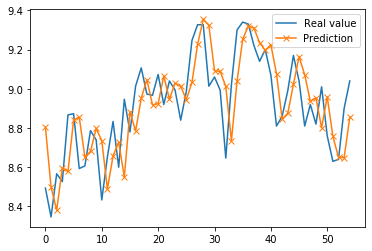

In [46]:
predict_kernel_ridge(historicStock[4])